# Baseline Modeling - Regression

---

* Goal: to develop baseline models prior to feature engineering to compare performance vs. post-engineered models.

My goal with this notebook is to develop a series of baseline models using minimal preprocessing. These models will establish a baseline performance for me to improve with additional feature engineering. Additionally, the most impactful features for each model can indicate if there are any features that are too strongly predictive.

---

In [1]:
# import duckdb
# from sqlalchemy import create_engine

import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sweetviz as sv

In [2]:
## SKLearn and Modeling Tools

from feature_engine.encoding import CountFrequencyEncoder, MeanEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.pipeline import Pipeline as fePipeline

from sklearn import metrics
from sklearn import set_config
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer, StandardScaler
from sklearn.tree import DecisionTreeRegressor

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import tensorflow as tf

from xgboost import XGBRegressor, XGBRFRegressor

set_config(transform_output='pandas')

## Load Data

In [3]:
# ## Connection and query settings to use reservations database

# con = create_engine("duckdb:///../../data/reservations.duckdb")

# q = '''SELECT *
# FROM Reservations
# JOIN guests
# ON reservations.uuid = guests.uuid
# JOIN Rooms
# ON reservations.uuid = rooms.uuid
# JOIN BookingAgents
# ON reservations.uuid = bookingagents.uuid'''

# # df_data = duckdb.sql(q).df()
# df_data = pd.read_sql(q, con)
# df_data

In [4]:
## Define index and column names to use for modeling

file_name = '../../data/column_groups.json'
          
with open(file_name, 'r') as json_file:
    data_list = json.load(json_file)
    
usecols = data_list['booking_details']
usecols.extend(data_list['temporal_features'])  # Extend first list with additional columns
usecols.remove('ArrivalDateYear')
usecols.remove('ReservationStatusDate')
usecols = set(usecols)                          # Remove duplicate column names
usecols.remove('UUID')
usecols

{'ADR',
 'Adults',
 'Agent',
 'ArrivalDateDayOfMonth',
 'ArrivalDateMonth',
 'ArrivalDateWeekNumber',
 'Babies',
 'Children',
 'Company',
 'Country',
 'CustomerType',
 'DepositType',
 'DistributionChannel',
 'HotelNumber',
 'LeadTime',
 'MarketSegment',
 'ReservedRoomType',
 'StaysInWeekNights',
 'StaysInWeekendNights'}

In [5]:
## Load only selected features from dataset - see EDA notebook for details
df_data = pd.read_feather('../../data/source/full_data.feather', columns = set(usecols))
df_data

,ArrivalDateMonth,Children,Country,DepositType,ADR,HotelNumber,StaysInWeekNights,Babies,LeadTime,MarketSegment,CustomerType,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,Company,ReservedRoomType,Agent,Adults,DistributionChannel
0,July,0.0,PRT,No Deposit,0.00,H1,0,0,342,Direct,Transient,27,1,0,NULL,C,NULL,2,Direct
1,July,0.0,PRT,No Deposit,0.00,H1,0,0,737,Direct,Transient,27,1,0,NULL,C,NULL,2,Direct
2,July,0.0,GBR,No Deposit,75.00,H1,1,0,7,Direct,Transient,27,1,0,NULL,A,NULL,1,Direct
3,July,0.0,GBR,No Deposit,75.00,H1,1,0,13,Corporate,Transient,27,1,0,NULL,A,304,1,Corporate
4,July,0.0,GBR,No Deposit,98.00,H1,2,0,14,Online TA,Transient,27,1,0,NULL,A,240,2,TA/TO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,August,0.0,BEL,No Deposit,96.14,H2,5,0,23,Offline TA/TO,Transient,35,30,2,NULL,A,394,2,TA/TO
119386,August,0.0,FRA,No Deposit,225.43,H2,5,0,102,Online TA,Transient,35,31,2,NULL,E,9,3,TA/TO
119387,August,0.0,DEU,No Deposit,157.71,H2,5,0,34,Online TA,Transient,35,31,2,NULL,D,9,2,TA/TO
119388,August,0.0,GBR,No Deposit,104.40,H2,5,0,109,Online TA,Transient,35,31,2,NULL,A,89,2,TA/TO


## Set Target Feature

In [6]:
target_feature = 'ADR'

## Quick Overview

                                             |          | [  0%]   00:00 -> (? left)


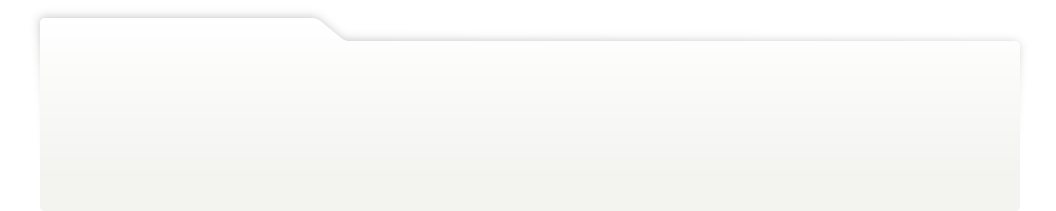
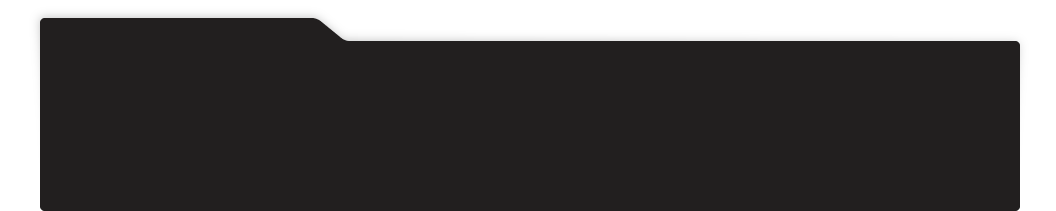
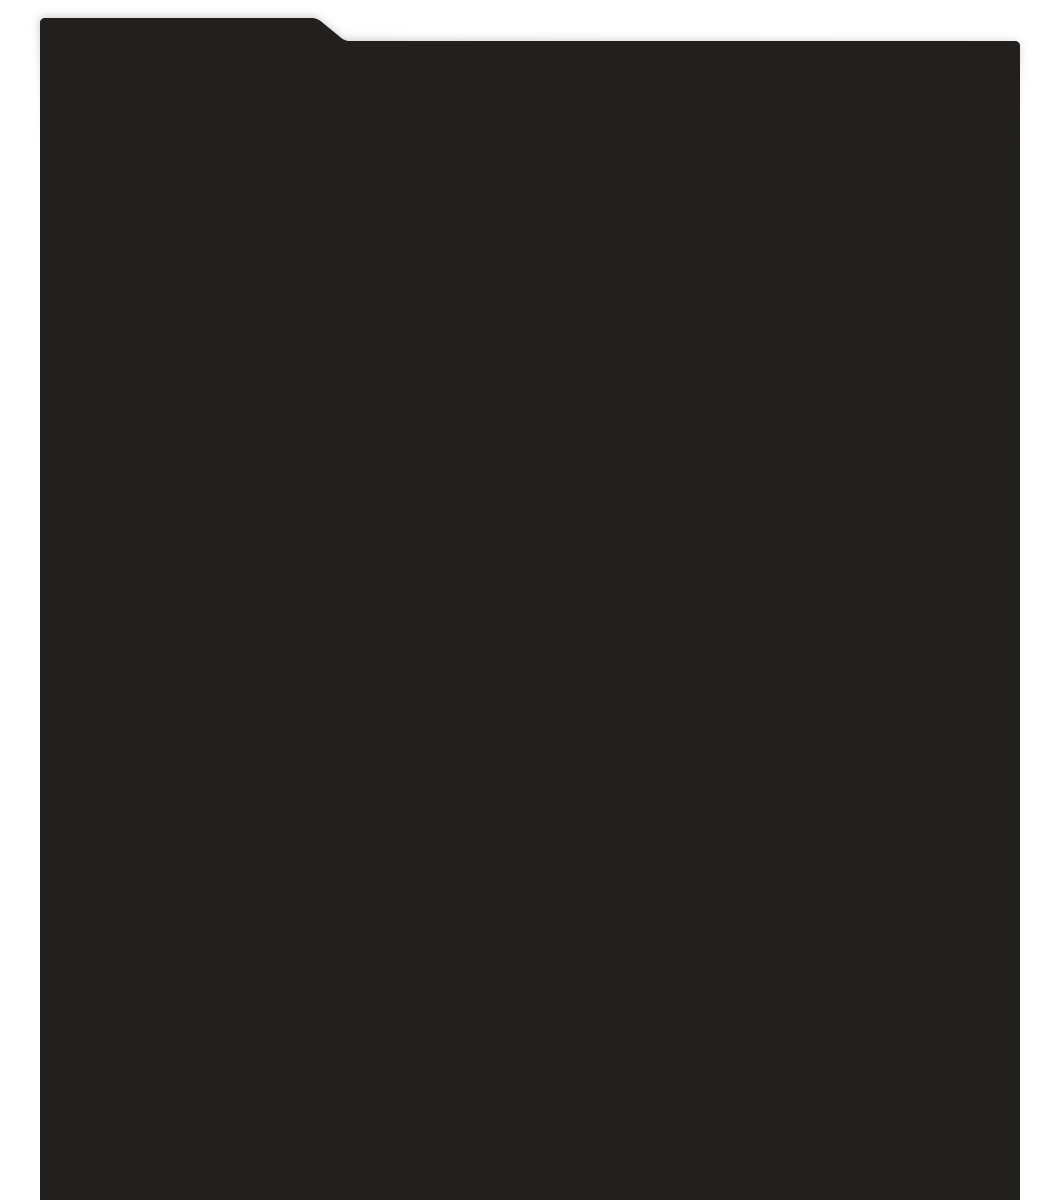
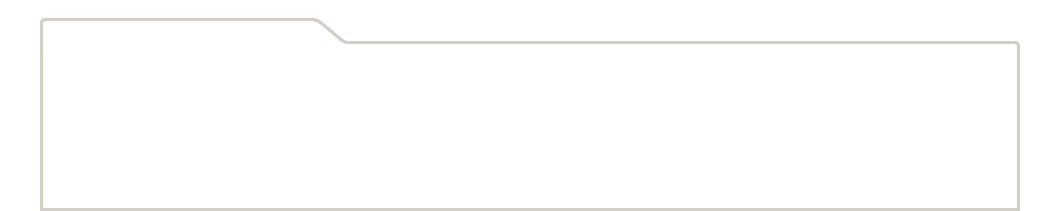
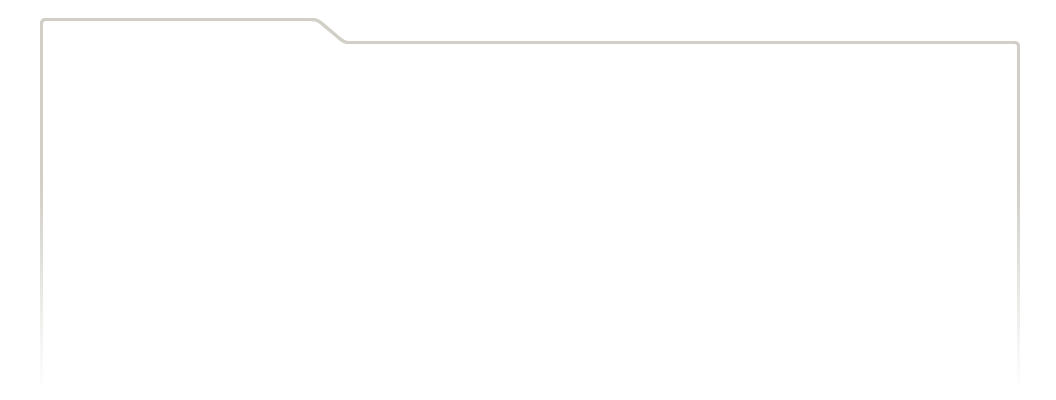
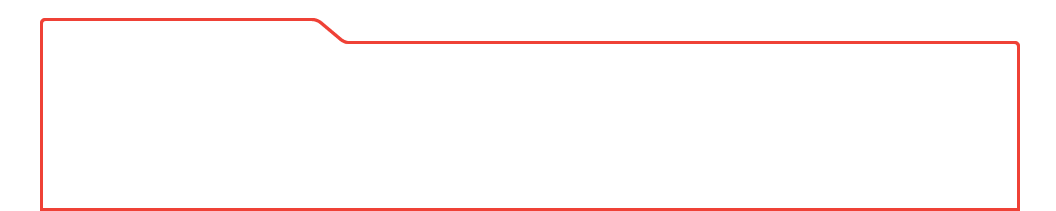
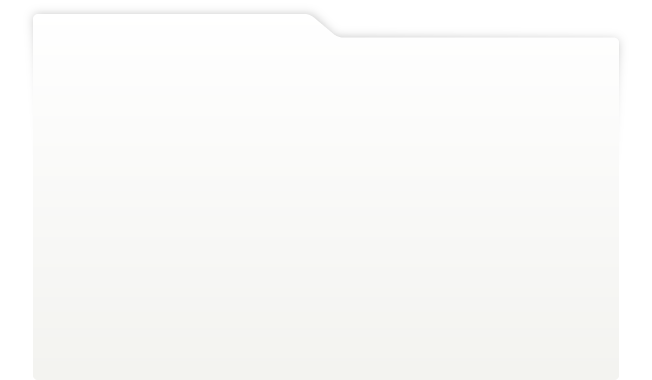
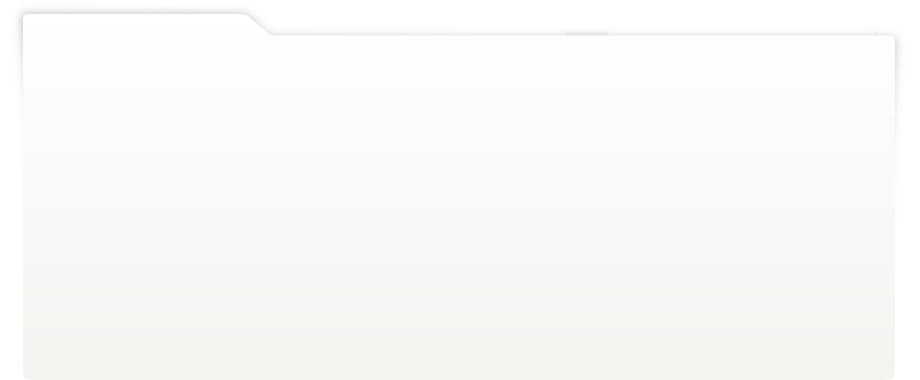
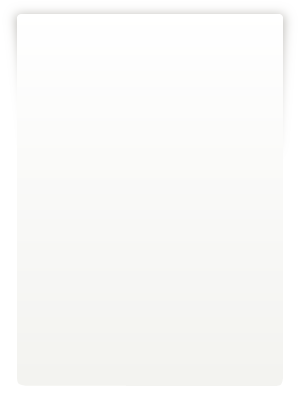
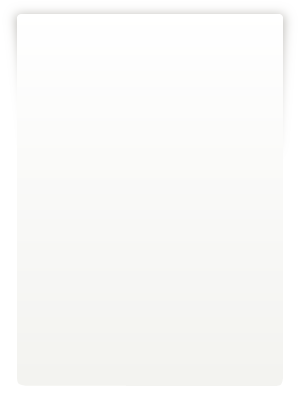
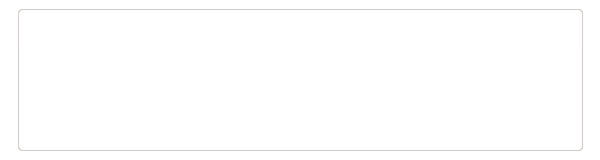
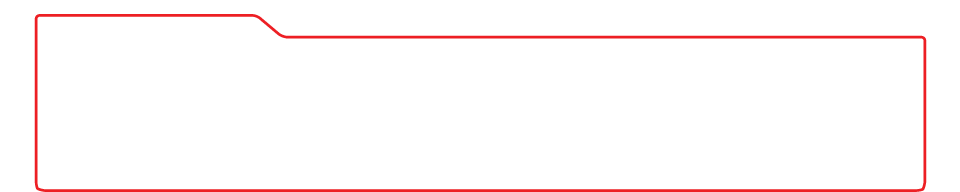
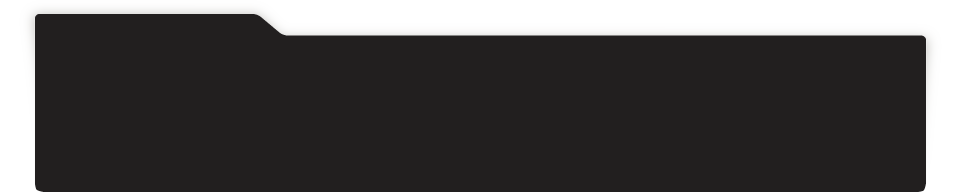
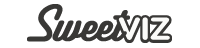
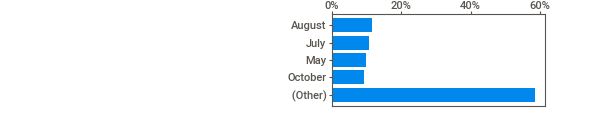
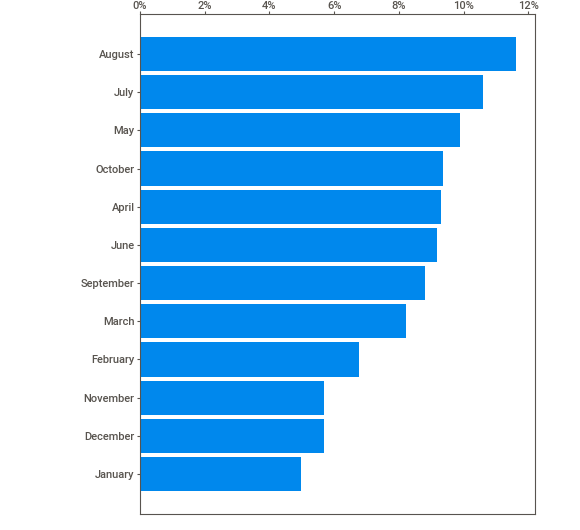
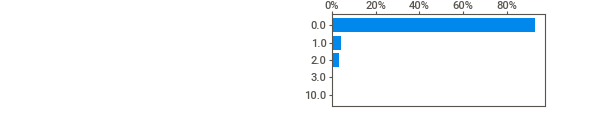
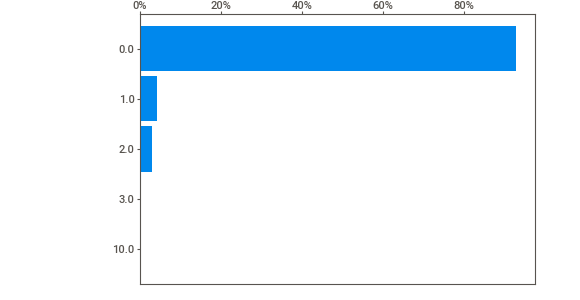
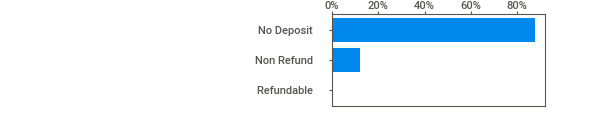
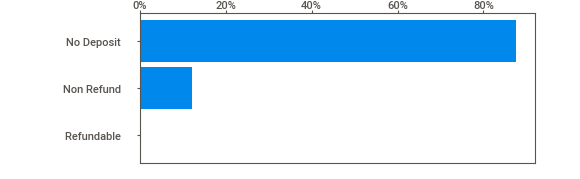
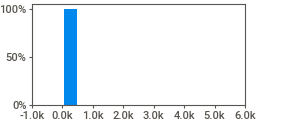
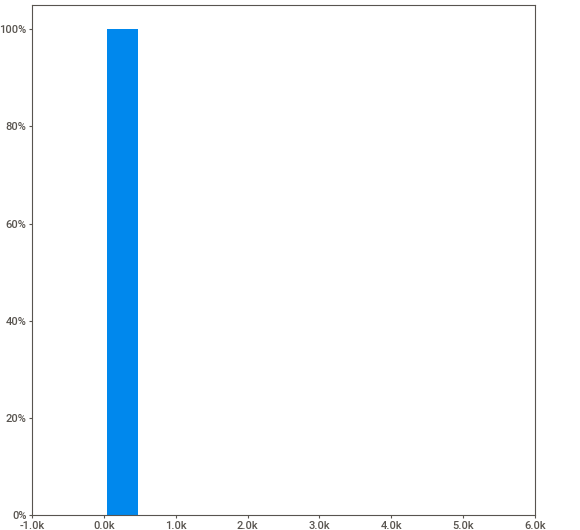
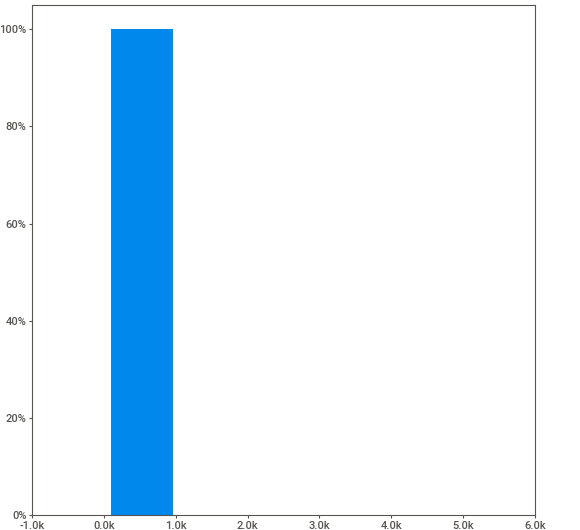
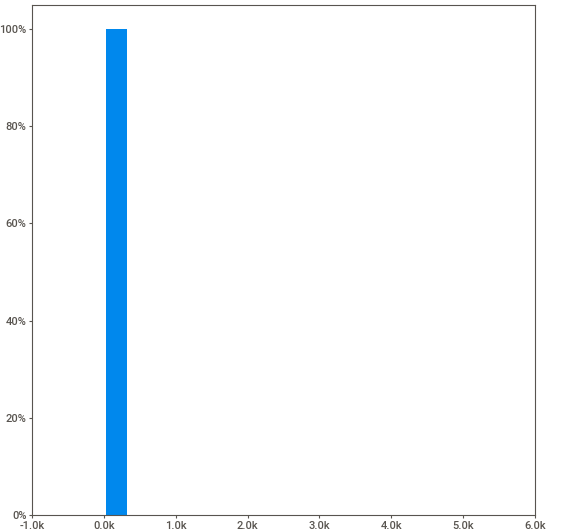
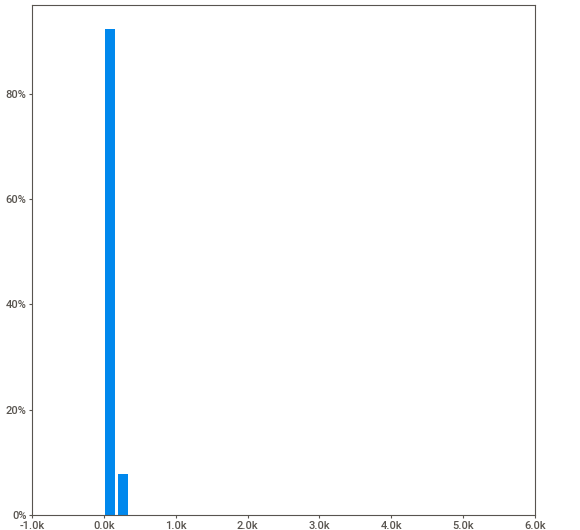
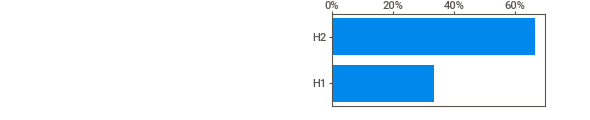
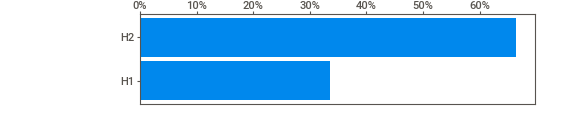
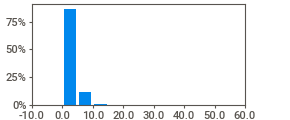
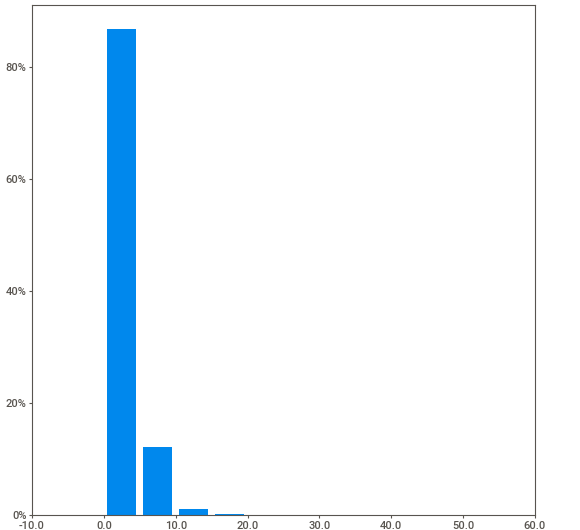
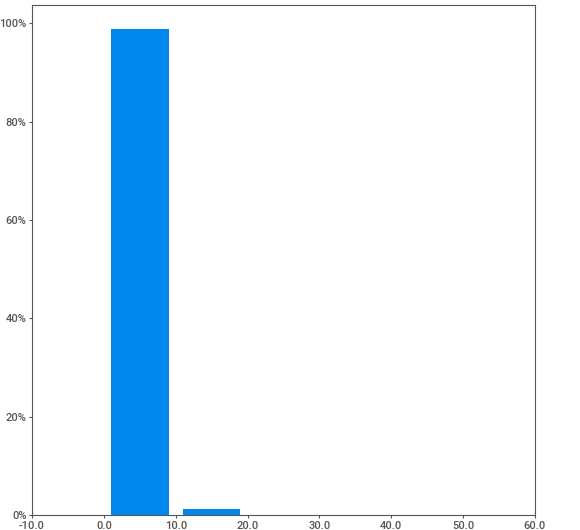
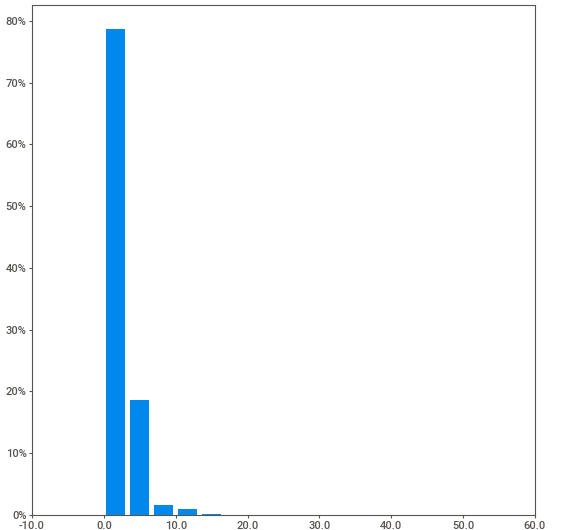
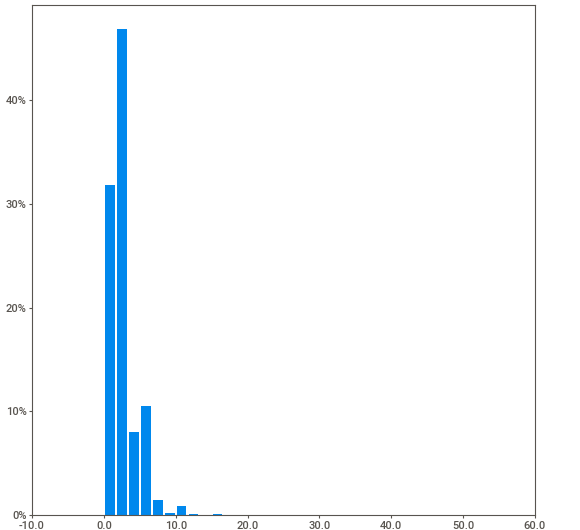
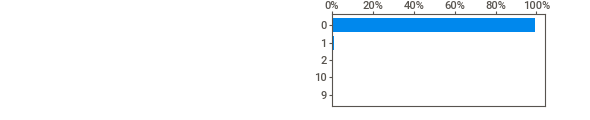
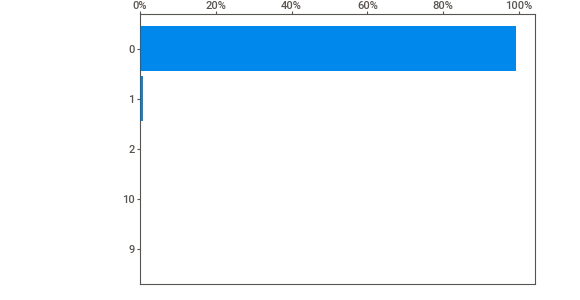
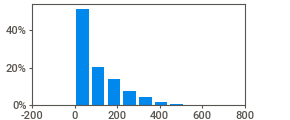
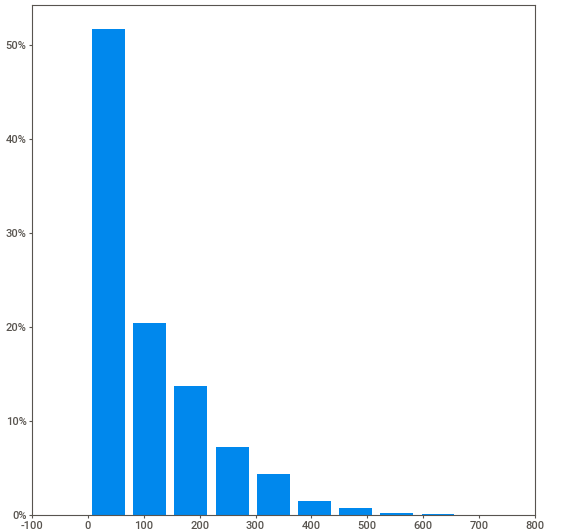
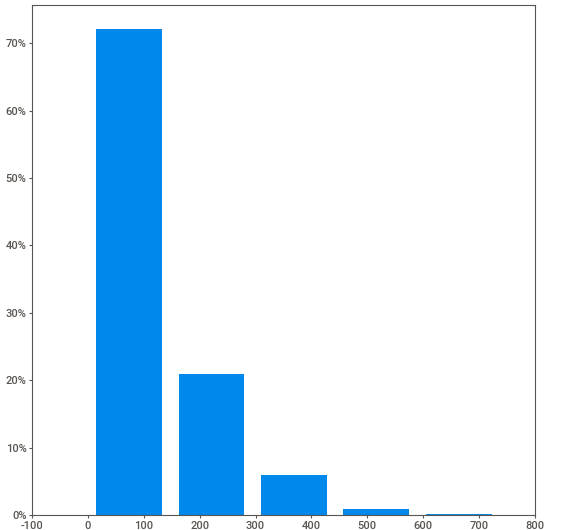
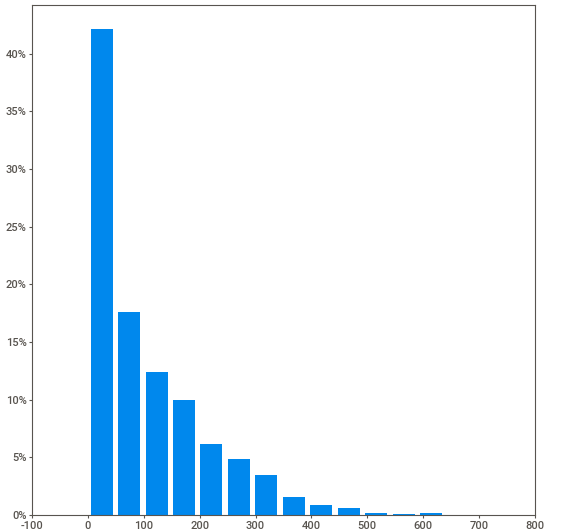
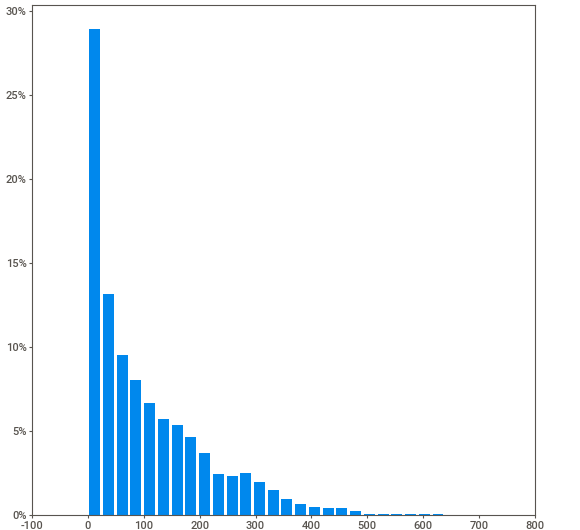
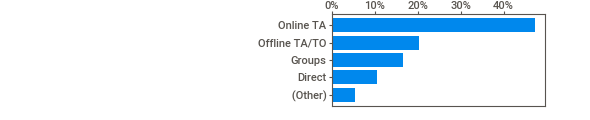
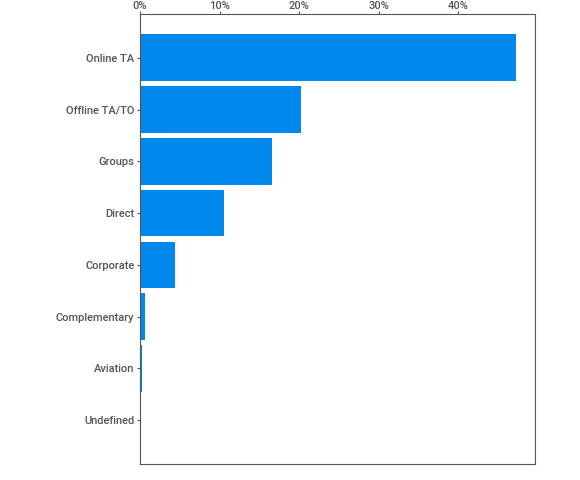
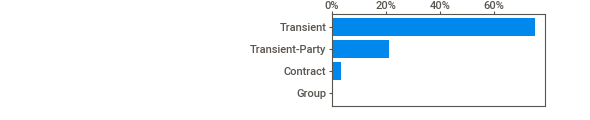
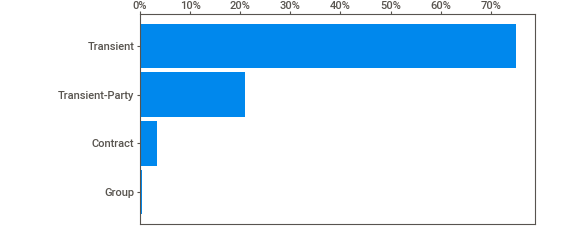
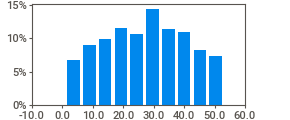
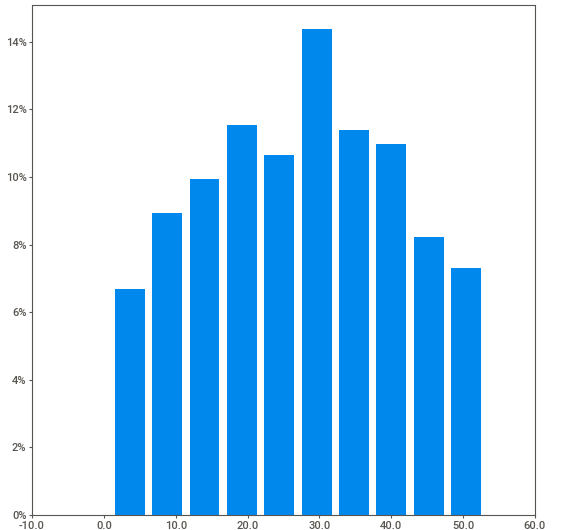
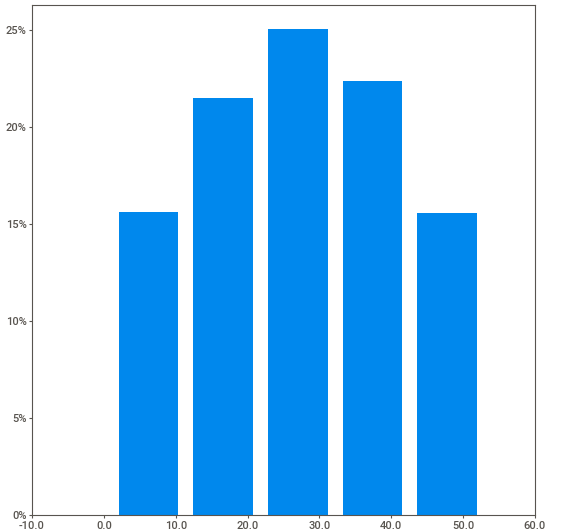
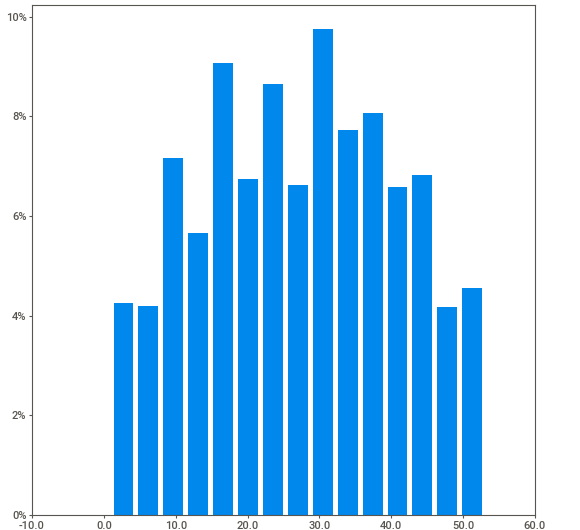
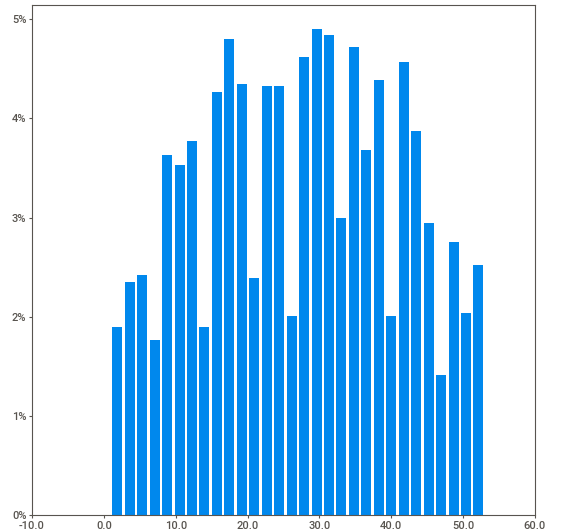
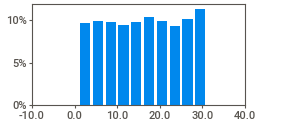
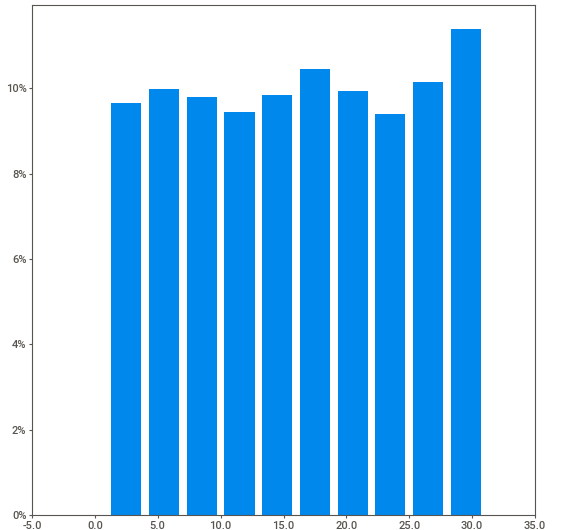
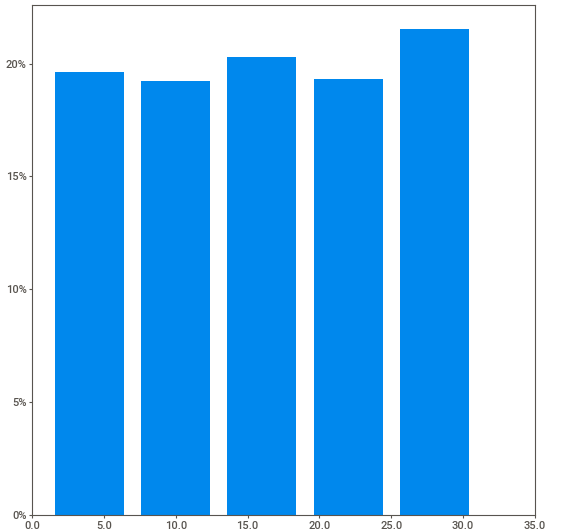
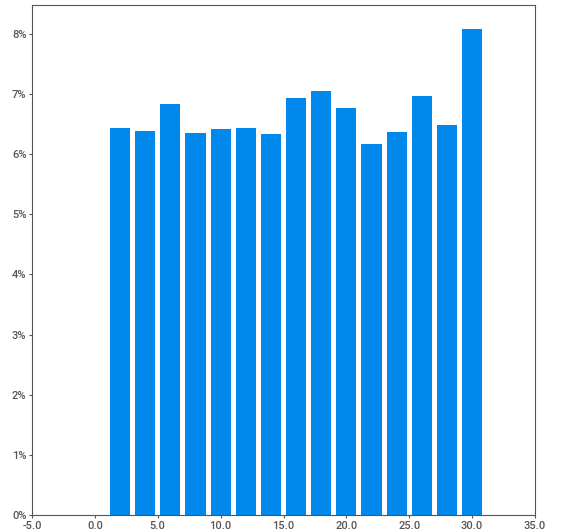
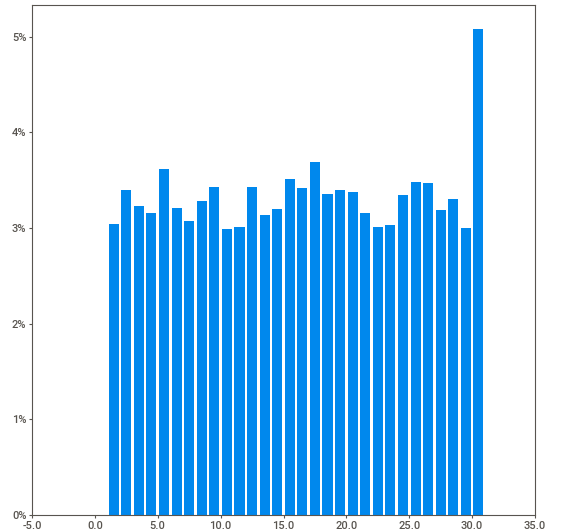
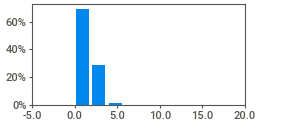
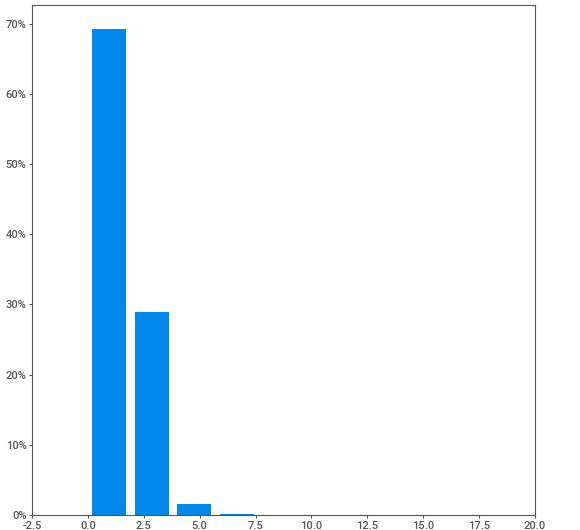
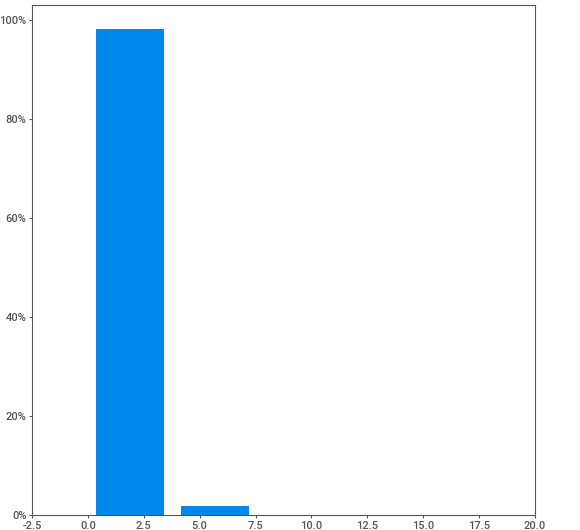
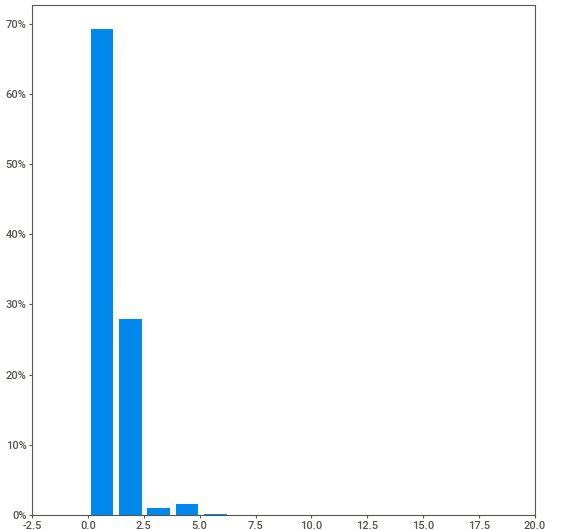
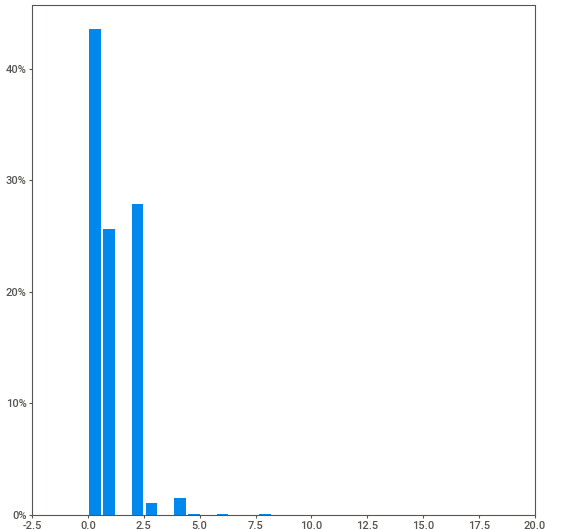
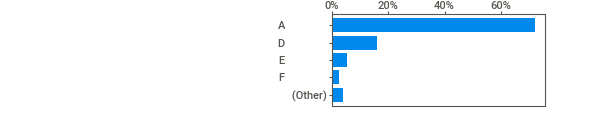
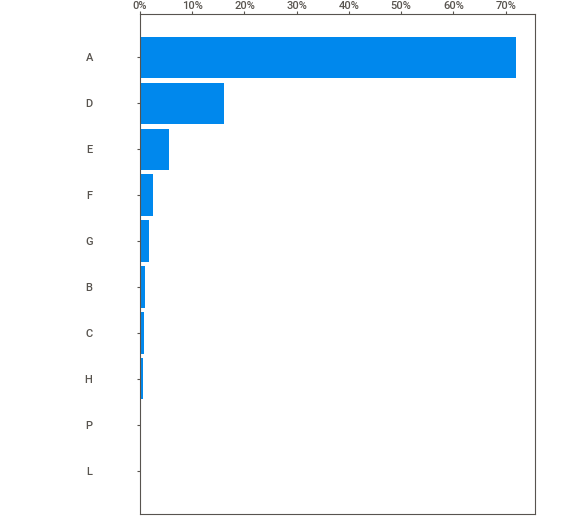
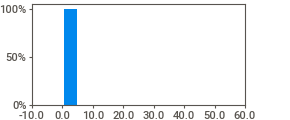
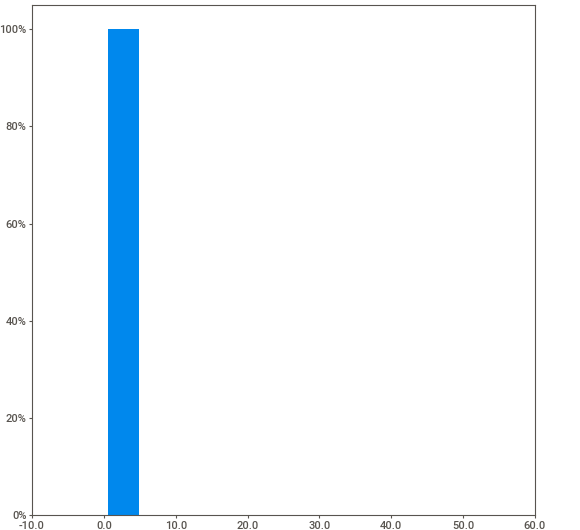
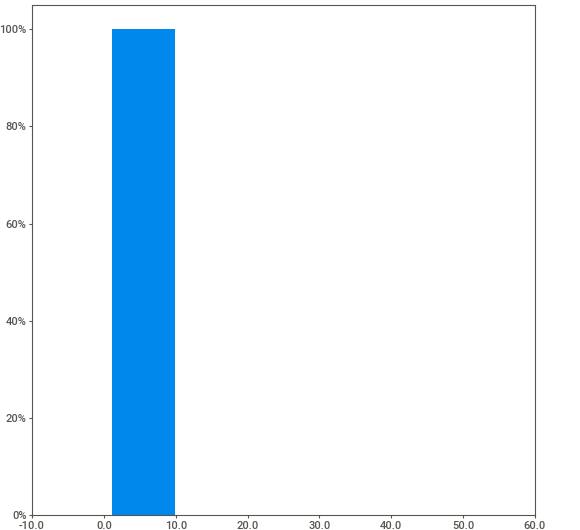
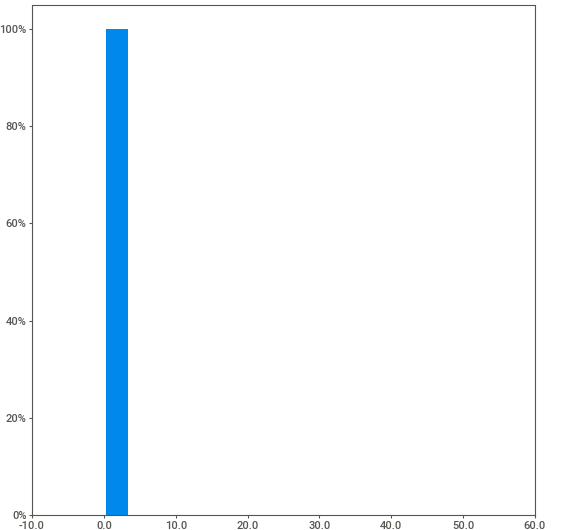
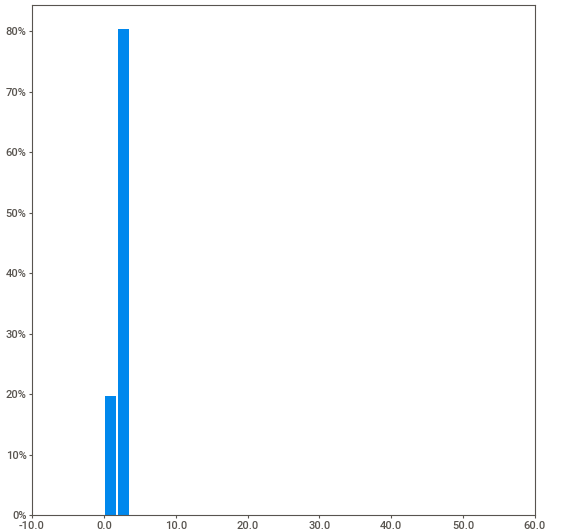
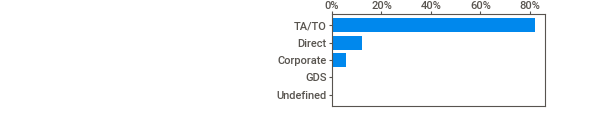
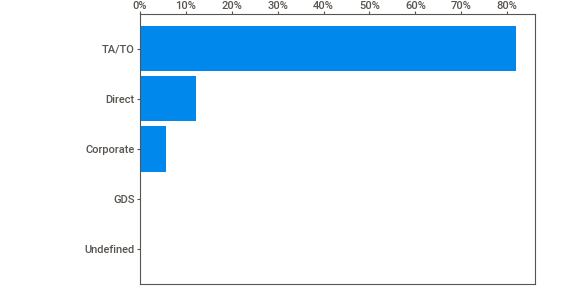

In [7]:
sv.analyze(df_data,pairwise_analysis = 'off').show_notebook()

---

**Quick Overview: Review**

Based on the quick EDA, I see there are both categorical features (several with high cardinality) and continuous features (right-skewed and with some extreme outliers).

---

# Train-Test Split

In [8]:
df_data.head()

,ArrivalDateMonth,Children,Country,DepositType,ADR,HotelNumber,StaysInWeekNights,Babies,LeadTime,MarketSegment,CustomerType,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,Company,ReservedRoomType,Agent,Adults,DistributionChannel
0,July,0.0,PRT,No Deposit,0.0,H1,0,0,342,Direct,Transient,27,1,0,NULL,C,NULL,2,Direct
1,July,0.0,PRT,No Deposit,0.0,H1,0,0,737,Direct,Transient,27,1,0,NULL,C,NULL,2,Direct
2,July,0.0,GBR,No Deposit,75.0,H1,1,0,7,Direct,Transient,27,1,0,NULL,A,NULL,1,Direct
3,July,0.0,GBR,No Deposit,75.0,H1,1,0,13,Corporate,Transient,27,1,0,NULL,A,304,1,Corporate
4,July,0.0,GBR,No Deposit,98.0,H1,2,0,14,Online TA,Transient,27,1,0,NULL,A,240,2,TA/TO


In [9]:
X = df_data.drop(columns = target_feature)
y = df_data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 903)

# Create Modeling Pipelines

---

Prior to performing any modeling, I will need to perform some prep work - namely filling missing values; encoding categorical features; handling outliers in numeric features; and scaling features (mostly for linear regression models).

Before I fit my data using my preprocessing pipeline, I will transform my target feature using a Yeo-Johnson transformation. This will help reduce the impact of outliers in the target features without removing data entirely. Since scikit-learn's TransformedTargetRegressor class automatically inverts the transformation, the resulting predictions will be immediately interpretable.

Finally, I will evaluate my model's performance based on the R^2 score; mean absolute error ("MAE"); median absolute error ("MedAE"); and the root mean squared error ("RMSE"). These metrics will give me several perspectives on the model's performance.

---

# Random Forest Regressor Pipeline

In [10]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(sparse_output=False,
                                                   handle_unknown='infrequent_if_exist',
                                                   max_categories=20))])

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('winsorizer', Winsorizer(capping_method='gaussian', tail='both', fold=3)),
                         ('scaler', StandardScaler()),
                         ('powertransformer', PowerTransformer(method='yeo-johnson'))
])

## --- Combine transformers into a single ColumnTransformer --- ##
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

## ---  Create the TransformedTargetRegressor with Yeo-Johnson transformation --- ##
target_transformer = PowerTransformer(method='yeo-johnson')

base_regressor = RandomForestRegressor(n_jobs = -1)

regressor = TransformedTargetRegressor(regressor=base_regressor,
                                       transformer=target_transformer)

## --- Build the full pipeline --- ##
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', regressor)])

## --- Fit the model and generate predictions --- ##
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

## --- Evaluate performance metrics --- ##
score_training = model_pipeline.score(X_train, y_train)
score_testing = model_pipeline.score(X_test, y_test)

print(f'\nTraining Score: {score_training:,.3f}\n'
      f'Testing Score: {score_testing:,.3f}\n'
      f'Difference: {score_training - score_testing:,.3f}\n')

mean_ae = metrics.mean_absolute_error(y_pred, y_test)
median_ae = metrics.median_absolute_error(y_pred, y_test)
mse = metrics.mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mse)


print(f'The MAE is ${mean_ae:,.2f}\n'
      f'The MedAE is ${median_ae:,.2f}\n'
      f'The RMSE is ${rmse:,.2f}\n')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(



Training Score: 0.959
Testing Score: 0.850
Difference: 0.109

The MAE is $9.86
The MedAE is $4.40
The RMSE is $18.67



## Model Tweaks

---



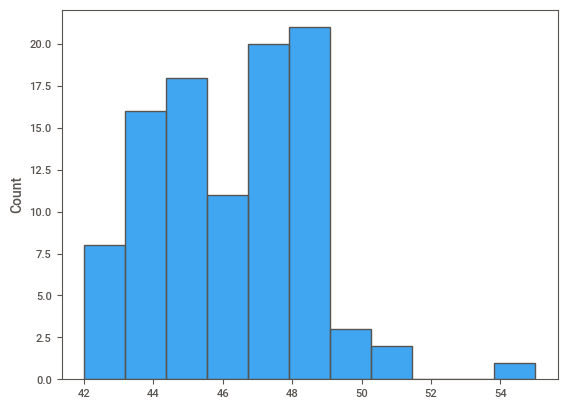

In [11]:
depths = [tree.get_depth() for tree in model_pipeline[-1].regressor_.estimators_]

sns.histplot(depths);

In [24]:
# Select categorical and numerical features
cat_feats = X_train.select_dtypes(include=['object']).columns
num_feats = X_train.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(sparse_output=False,
                                                   handle_unknown='infrequent_if_exist',
                                                   max_categories=20))])

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('winsorizer', Winsorizer(capping_method='gaussian', tail='both', fold=3)),
                         ('scaler', StandardScaler()),
                         ('powertransformer', PowerTransformer(method='yeo-johnson'))
])

## --- Combine transformers into a single ColumnTransformer --- ##
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

## ---  Create the TransformedTargetRegressor with Yeo-Johnson transformation --- ##
target_transformer = PowerTransformer(method='yeo-johnson')


base_regressor = RandomForestRegressor(n_jobs=-1)

regressor = TransformedTargetRegressor(regressor=base_regressor,
                                       transformer=target_transformer)

# Build the full pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Set up hyperparameter tuning with HalvingGridSearchCV
param_grid = {
    'regressor__regressor__max_depth': [30,40],
    'regressor__regressor__min_samples_split': [2, 5],
    'regressor__regressor__min_samples_leaf': [2, 4]
}

halving_grid_search = HalvingGridSearchCV(model_pipeline,
                                          param_grid,
                                          scoring='neg_median_absolute_error',
                                          cv=3,
                                        #   n_jobs=-1,
                                          factor=2,
                                          min_resources="exhaust")

# Fit the model and generate predictions
halving_grid_search.fit(X_train, y_train)

gridsearched_model = halving_grid_search.best_estimator_

y_pred = gridsearched_model.predict(X_test)

# Evaluate performance metrics
score_training = gridsearched_model.score(X_train, y_train)
score_testing = gridsearched_model.score(X_test, y_test)

print(f'\nTraining Score: {score_training:,.2f}\n'
      f'Testing Score: {score_testing:,.2f}\n'
      f'Difference: {score_training - score_testing:,.2f}\n')

mean_ae = metrics.mean_absolute_error(y_test, y_pred)
median_ae = metrics.median_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'The MAE is ${mean_ae:,.2f}\n'
      f'The MedAE is ${median_ae:,.2f}\n'
      f'The RMSE is ${rmse:,.2f}\n')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has featur


Training Score: 0.87
Testing Score: 0.83
Difference: 0.04

The MAE is $11.11
The MedAE is $5.33
The RMSE is $20.01



In [16]:
halving_grid_search.best_estimator_.named_steps['regressor'].get_params()['regressor__max_depth']

30

In [17]:
print(f'The median actual ADR is ${round(y_test.median(),2)}.\n'
      f'''The model's predictions are off by about {round(median_ae/y_test.median()*100,2)}%''')

The average actual ADR is $95.0.
The model's predictions are off by about 5.15%


## Model Inspection - Permutation Importances

---

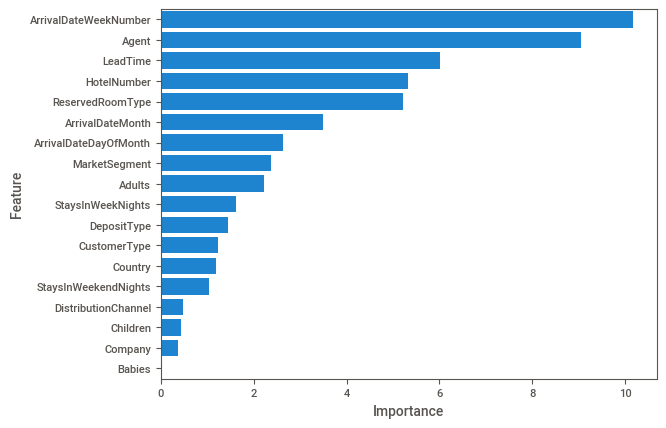

In [18]:
# Calculate permutation importances
result = permutation_importance(halving_grid_search.best_estimator_,
                                X_test, y_test,
                                scoring = 'neg_median_absolute_error',
                                random_state=42,
                                n_jobs=-1)

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df);

## Revised Model - Post-Permutation Importances

In [20]:
importance_df['Feature'][:10]

0    ArrivalDateWeekNumber
1                    Agent
2                 LeadTime
3              HotelNumber
4         ReservedRoomType
5         ArrivalDateMonth
6    ArrivalDateDayOfMonth
7            MarketSegment
8                   Adults
9        StaysInWeekNights
Name: Feature, dtype: object

In [21]:
X = df_data[importance_df['Feature'][:10]]
y = df_data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 903)

In [25]:
# Select categorical and numerical features
cat_feats = X_train.select_dtypes(include=['object']).columns
num_feats = X_train.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(sparse_output=False,
                                                   handle_unknown='infrequent_if_exist',
                                                   max_categories=20))])

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('winsorizer', Winsorizer(capping_method='gaussian', tail='both', fold=3)),
                         ('scaler', StandardScaler()),
                         ('powertransformer', PowerTransformer(method='yeo-johnson'))
])

## --- Combine transformers into a single ColumnTransformer --- ##
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

## ---  Create the TransformedTargetRegressor with Yeo-Johnson transformation --- ##
target_transformer = PowerTransformer(method='yeo-johnson')


base_regressor = RandomForestRegressor(n_jobs=-1)

regressor = TransformedTargetRegressor(regressor=base_regressor,
                                       transformer=target_transformer)

# Build the full pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Set up hyperparameter tuning with HalvingGridSearchCV
param_grid = {
    'regressor__regressor__max_depth': [30,40],
    'regressor__regressor__min_samples_split': [2, 5],
    'regressor__regressor__min_samples_leaf': [2, 4]
}

halving_grid_search = HalvingGridSearchCV(model_pipeline,
                                          param_grid,
                                          scoring='neg_median_absolute_error',
                                          cv=3,
                                        #   n_jobs=-1,
                                          factor=2,
                                          min_resources="exhaust")

# Fit the model and generate predictions
halving_grid_search.fit(X_train, y_train)

top_ten_features_model = halving_grid_search.best_estimator_

y_pred = top_ten_features_model.predict(X_test)

# Evaluate performance metrics
score_training = top_ten_features_model.score(X_train, y_train)
score_testing = top_ten_features_model.score(X_test, y_test)

print(f'\nTraining Score: {score_training:,.2f}\n'
      f'Testing Score: {score_testing:,.2f}\n'
      f'Difference: {score_training - score_testing:,.2f}\n')

mean_ae = metrics.mean_absolute_error(y_test, y_pred)
median_ae = metrics.median_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'The MAE is ${mean_ae:,.2f}\n'
      f'The MedAE is ${median_ae:,.2f}\n'
      f'The RMSE is ${rmse:,.2f}\n')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has featur


Training Score: 0.87
Testing Score: 0.83
Difference: 0.04

The MAE is $11.10
The MedAE is $5.41
The RMSE is $19.95



## Save Model to Joblib

In [26]:
best_model = gridsearched_model
# best_model = top_ten_features_model

In [27]:
joblib.dump(best_model,
            '../../data/baseline_regression_model.joblib',
            compress = 9)

['../../data/baseline_regression_model.joblib']

In [28]:
saved_model = joblib.load('../../data/baseline_regression_model.joblib')
saved_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('winsorizer',
                                                                   Winsorizer(fold=3,
                                                                              tail='both')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  Index(['ArrivalDateWeekNumber', 'LeadTime', 'ArrivalDateDayOfMonth', 'Adults',
       'StaysInWeekNights'],
      dtype=...
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 max_categories=20,
                                                                                 sparse_output=False))]),
                                                  Index(['Agent', 'HotelNumber', 'ReservedRoomType', 'ArrivalDateMonth',
       'MarketSegment'],
      dtype='object'))])),
                ('regressor',
                 TransformedTargetRegressor(regressor=RandomForestRegressor(max_depth=40,
                                                                            min_samples_leaf=2,
                                                                            n_jobs=-1),
                                            transformer=PowerTransformer()))])

In [29]:
saved_model.score(X_test, y_test)

0.8279509418834243

# DummyRegressor Pipeline

In [31]:
# Define the target transformer
target_transformer = PowerTransformer(method='yeo-johnson')

# Instantiate the model
base_regressor = DummyRegressor()

# Create the TransformedTargetRegressor with Yeo-Johnson transformation
regressor = TransformedTargetRegressor(regressor=base_regressor,
                                       transformer=target_transformer)

# Build the pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Fit the pipeline to the training data
model_pipeline.fit(X_train, y_train)

# Predict using the pipeline
y_pred = model_pipeline.predict(X_test)
score_training = model_pipeline.score(X_train, y_train)
score_testing = model_pipeline.score(X_test, y_test)

print(f'\nTraining Score: {score_training:,.3f}\n'
      f'Testing Score: {score_testing:,.3f}\n'
      f'Difference: {score_training - score_testing:,.3f}\n')

mean_ae = metrics.mean_absolute_error(y_pred, y_test)
median_ae = metrics.median_absolute_error(y_pred, y_test)
mse = metrics.mean_squared_error(y_pred, y_test)
rmse = np.log2(mse)


print(f'The MAE is ${mean_ae:,.2f}\n'
      f'The MedAE is ${median_ae:,.2f}\n'
      f'The RMSE is ${rmse:,.2f}\n')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(



Training Score: -0.009
Testing Score: -0.011
Difference: 0.002

The MAE is $35.89
The MedAE is $28.36
The RMSE is $11.20



# Decision Tree Regressor

In [32]:
# Select categorical and numerical features
cat_feats = X_train.select_dtypes(include=['object']).columns
num_feats = X_train.select_dtypes(include=['number']).columns

# Create separate pipelines for categorical and numeric features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', CountFrequencyEncoder(unseen='encode', encoding_method='frequency', missing_values='ignore'))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('powertransformer', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

# Create the TransformedTargetRegressor with Yeo-Johnson transformation
target_transformer = PowerTransformer(method='yeo-johnson')

base_regressor = DecisionTreeRegressor()

regressor = TransformedTargetRegressor(regressor=base_regressor, transformer=target_transformer)

# Build the full pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Set up hyperparameter tuning with HalvingGridSearchCV
param_grid = {
    'regressor__regressor__max_depth': [5, 10, 20, 30],
    'regressor__regressor__min_samples_split': [2, 5, 10],
    'regressor__regressor__min_samples_leaf': [2, 4, 8],
    'regressor__regressor__max_features': ['sqrt', 'log2', 0.5]
}

halving_grid_search = HalvingGridSearchCV(model_pipeline,
                                          param_grid,
                                          scoring='neg_median_absolute_error',
                                          cv=3,
                                          n_jobs=-1,
                                          factor=2,
                                          random_state=42)

# Fit the model and generate predictions
halving_grid_search.fit(X_train, y_train)

best_model = halving_grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Evaluate performance metrics
score_training = best_model.score(X_train, y_train)
score_testing = best_model.score(X_test, y_test)

print(f'\nTraining Score: {score_training:,.3f}\n'
      f'Testing Score: {score_testing:,.3f}\n'
      f'Difference: {score_training - score_testing:,.3f}\n')

mean_ae = metrics.mean_absolute_error(y_test, y_pred)
median_ae = metrics.median_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'The MAE is ${mean_ae:,.2f}\n'
      f'The MedAE is ${median_ae:,.2f}\n'
      f'The RMSE is ${rmse:,.2f}\n')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(



Training Score: 0.834
Testing Score: 0.750
Difference: 0.084

The MAE is $13.00
The MedAE is $5.22
The RMSE is $24.14



# HistGradientBoostingRegressor

In [33]:
## --- Create separate pipelines for categorical and numeric features --- ##

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', CountFrequencyEncoder(unseen = 'encode',
                                                           encoding_method = 'frequency',
                                                           missing_values = 'ignore'))])

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler()),
                         ('powertransformer', PowerTransformer(method = 'yeo-johnson'))])

## --- Combine transformers into a single ColumnTransformer --- ##
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

## ---  Create the TransformedTargetRegressor with Yeo-Johnson transformation --- ##
target_transformer = PowerTransformer(method='yeo-johnson')

base_regressor = HistGradientBoostingRegressor(loss = 'absolute_error')

regressor = TransformedTargetRegressor(regressor=base_regressor,
                                       transformer=target_transformer)

## --- Build the full pipeline --- ##
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', regressor)])

## --- Fit the model and generate predictions --- ##
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

## --- Evaluate performance metrics --- ##
score_training = model_pipeline.score(X_train, y_train)
score_testing = model_pipeline.score(X_test, y_test)

print(f'\nTraining Score: {score_training:,.3f}\n'
      f'Testing Score: {score_testing:,.3f}\n'
      f'Difference: {score_training - score_testing:,.3f}\n')

mean_ae = metrics.mean_absolute_error(y_pred, y_test)
median_ae = metrics.median_absolute_error(y_pred, y_test)
mse = metrics.mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mse)


print(f'The MAE is ${mean_ae:,.2f}\n'
      f'The MedAE is ${median_ae:,.2f}\n'
      f'The RMSE is ${rmse:,.2f}\n')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(



Training Score: 0.671
Testing Score: 0.759
Difference: -0.089

The MAE is $15.17
The MedAE is $9.74
The RMSE is $23.66



In [34]:
# Define the target transformer
target_transformer = PowerTransformer(method='yeo-johnson')

# Instantiate the model
base_regressor = HistGradientBoostingRegressor(random_state = 903)

# Create the TransformedTargetRegressor with Yeo-Johnson transformation
regressor = TransformedTargetRegressor(regressor=base_regressor,
                                       transformer=target_transformer)

# Build the pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Fit the pipeline to the training data
model_pipeline.fit(X_train, y_train)

# Predict using the pipeline
y_pred = model_pipeline.predict(X_test)
score_training = model_pipeline.score(X_train, y_train)
score_testing = model_pipeline.score(X_test, y_test)

print(f'\nTraining Score: {score_training:,.3f}\n'
      f'Testing Score: {score_testing:,.3f}\n'
      f'Difference: {score_training - score_testing:,.3f}\n')

mean_ae = metrics.mean_absolute_error(y_pred, y_test)
median_ae = metrics.median_absolute_error(y_pred, y_test)
mse = metrics.mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mse)


print(f'The MAE is ${mean_ae:,.2f}\n'
      f'The MedAE is ${median_ae:,.2f}\n'
      f'The RMSE is ${rmse:,.2f}\n')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(



Training Score: 0.725
Testing Score: 0.804
Difference: -0.079

The MAE is $14.47
The MedAE is $10.11
The RMSE is $21.34



# SGDRegressor

In [35]:
# Define the target transformer
target_transformer = PowerTransformer(method='yeo-johnson')

# Instantiate the model
base_regressor = SGDRegressor(loss='huber',penalty='elasticnet')

# Create the TransformedTargetRegressor with Yeo-Johnson transformation
regressor = TransformedTargetRegressor(regressor=base_regressor,
                                       transformer=target_transformer)

# Build the pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Fit the pipeline to the training data
model_pipeline.fit(X_train, y_train)

# Predict using the pipeline
y_pred = model_pipeline.predict(X_test)
score_training = model_pipeline.score(X_train, y_train)
score_testing = model_pipeline.score(X_test, y_test)

print(f'\nTraining Score: {score_training:,.3f}\n'
      f'Testing Score: {score_testing:,.3f}\n'
      f'Difference: {score_training - score_testing:,.3f}\n')

mean_ae = metrics.mean_absolute_error(y_pred, y_test)
median_ae = metrics.median_absolute_error(y_pred, y_test)
mse = metrics.mean_squared_error(y_pred, y_test)
rmse = np.log2(mse)


print(f'The MAE is ${mean_ae:,.2f}\n'
      f'The MedAE is ${median_ae:,.2f}\n'
      f'The RMSE is ${rmse:,.2f}\n')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(



Training Score: 0.256
Testing Score: 0.304
Difference: -0.048

The MAE is $28.99
The MedAE is $21.75
The RMSE is $10.66



# XGBRegressor

In [36]:
# Define the target transformer
target_transformer = PowerTransformer(method='yeo-johnson')

# Instantiate the model
base_regressor = XGBRegressor(objective='reg:squarederror')

# Create the TransformedTargetRegressor with Yeo-Johnson transformation
regressor = TransformedTargetRegressor(regressor=base_regressor,
                                       transformer=target_transformer)

# Build the pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Fit the pipeline to the training data
model_pipeline.fit(X_train, y_train)

# Predict using the pipeline
y_pred = model_pipeline.predict(X_test)
score_training = model_pipeline.score(X_train, y_train)
score_testing = model_pipeline.score(X_test, y_test)

print(f'\nTraining Score: {score_training:,.3f}\n'
      f'Testing Score: {score_testing:,.3f}\n'
      f'Difference: {score_training - score_testing:,.3f}\n')

mean_ae = metrics.mean_absolute_error(y_pred, y_test)
median_ae = metrics.median_absolute_error(y_pred, y_test)
mse = metrics.mean_squared_error(y_pred, y_test)
rmse = np.log2(mse)


print(f'The MAE is ${mean_ae:,.2f}\n'
      f'The MedAE is ${median_ae:,.2f}\n'
      f'The RMSE is ${rmse:,.2f}\n')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(



Training Score: 0.842
Testing Score: 0.840
Difference: 0.002

The MAE is $12.53
The MedAE is $8.16
The RMSE is $8.54



## XGBoost Random Forest Regressor

In [37]:
# Define the target transformer
target_transformer = PowerTransformer(method='yeo-johnson')

# # Instantiate the model
# base_regressor = XGBRFRegressor(objective='reg:squarederror')

# Instantiate the model
regressor = XGBRFRegressor(objective='reg:squarederror')

# # Create the TransformedTargetRegressor with Yeo-Johnson transformation
# regressor = TransformedTargetRegressor(regressor=base_regressor,
#                                        transformer=target_transformer)

# Build the pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Define parameter grid for GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__subsample': [0.5, 0.7, 1.0],
    'regressor__colsample_bytree': [0.5, 0.7, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(model_pipeline,
                           param_grid,
                           cv=5,
                           scoring='neg_median_absolute_error',
                           n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Predict using the pipeline
y_pred = grid_search.predict(X_test)
score_training = grid_search.score(X_train, y_train)
score_testing = grid_search.score(X_test, y_test)

print(f'\nTraining Score: {score_training:,.3f}\n'
      f'Testing Score: {score_testing:,.3f}\n'
      f'Difference: {score_training - score_testing:,.3f}\n')

mean_ae = metrics.mean_absolute_error(y_pred, y_test)
median_ae = metrics.median_absolute_error(y_pred, y_test)
mse = metrics.mean_squared_error(y_pred, y_test)
rmse = np.log2(mse)


print(f'The MAE is ${mean_ae:,.2f}\n'
      f'The MedAE is ${median_ae:,.2f}\n'
      f'The RMSE is ${rmse:,.2f}\n')

KeyboardInterrupt: 

# Simple Neural Net

In [ ]:
X = df_data.drop(columns = target_feature)
y = df_data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 903)

In [ ]:
# Identify numerical and categorical features
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

# cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
#                          ('encoder', CountFrequencyEncoder(unseen = 'encode',
#                                                            encoding_method = 'frequency',
#                                                            missing_values='ignore'))])

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(drop = 'first',
                                                   sparse_output=False,
                                                   handle_unknown='infrequent_if_exist',
                                                   max_categories=15))])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('winsorizer', Winsorizer(capping_method='gaussian', tail='both', fold=3)),
    ('scaler', MinMaxScaler()),
    ('powertransformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)

# Preprocess the features
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Perform Yeo-Johnson transformation on the target
target_transformer = PowerTransformer(method='yeo-johnson')
y_train_transformed = target_transformer.fit_transform(y_train.values.reshape(-1, 1))
y_test_transformed = target_transformer.transform(y_test.values.reshape(-1, 1))

# Convert data to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_transformed = tf.convert_to_tensor(y_train_transformed, dtype=tf.float32)
y_test_transformed = tf.convert_to_tensor(y_test_transformed, dtype=tf.float32)

In [ ]:
def build_model():
        # Build the single-layer neural network model
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    # Compile the model with the Adam optimizer and a learning rate scheduler
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='mean_absolute_error')
    model.summary()
    return model

In [ ]:
# # !pip install dojo-ds
# import dojo_ds as ds 
# help(ds.evaluate.plot_history)

In [ ]:
# Train the model
model = build_model()
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

In [ ]:

# Evaluate the model
loss = model.evaluate(X_train, y_train, verbose=1)
print(f'Mean Absolute Error on Training Data: {loss:.2f}')

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=1)
print(f'Mean Absolute Error on Test Data: {loss:.2f}')

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance metrics
mean_ae = metrics.mean_absolute_error(y_test, y_pred)
median_ae = metrics.median_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'\nThe MAE is ${mean_ae:.2f}\n'
      f'The MedAE is ${median_ae:.2f}\n'
      f'The RMSE is ${rmse:.2f}\n')

# ds.evaluate.plot_history(history)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.plot(marker = 'o');

# Final Results

---

The best model was the Random Forest Regressor model. This model performed well with minor preprocessing, leading me to believe there may be features that are strongly predictive of the ADR. I will need to investigate further to confirm.

My next steps will be to perform additional EDA and feature engineering. During the EDA process, I will identify and remove any features that would not be known before the guest's stay. Then, I will engineer new features, including temporal features related to booking and stay dates, as well as hotel occupancy rates.

The end goal is to ensure my final dataset properly represents reservations prior to the guest stay and includes additional detail not present in the initial dataset.

---